# Caustiques

In [1]:
# %pip install -U -r requirements.txt

In [2]:
import numpy as np
# import cv2
from tqdm.auto import trange, tqdm
import matplotlib
# import matplotlib.gridspec as gs
from matplotlib.gridspec import SubplotParams
import numpy as np
from scipy import ndimage
# from scipy.ndimage import zoom
matplotlib.__version__

'3.10.7'

In [3]:
%matplotlib inline

In [4]:
import os 
from IPython import get_ipython
ip = get_ipython()
# print(ip.user_ns)
study_name = None
if '__vsc_ipynb_file__' in ip.user_ns:
    # https://github.com/msm1089/ipynbname/issues/17
    study_name = os.path.split(os.path.basename(ip.user_ns['__vsc_ipynb_file__']))[1]
elif '__file__' in ip.user_ns:
    study_name = ip.user_ns['__file__']
else:
    import ipynbname
    study_name = ipynbname.name()
study_name = study_name.replace('.ipynb', '')
study_name

'2025-11-06_caustique-transition'

In [5]:
# %ls -lh {study_name}
# %ls -lh /tmp/{study_name}

In [6]:
# %rm -fr {study_name}
# %rm -fr ~/tmp/{study_name}

In [7]:
# the higher PRECISION, the bigger the file
PRECISION = 4  # debugging
PRECISION = 8 # low quality
PRECISION = 10 # medium quality
PRECISION = 11 # medium+ quality
PRECISION = 12 # good quality
# PRECISION = 14 # very good quality
# PRECISION = 15 # for production

# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass

@dataclass
class init:
    figpath: str = study_name # Folder to store images
    phi: float = 1.61803 # beauty is gold
    tag: str = 'trier' # Tag
    ext: str = 'mp4' # Extension for output
    nx: int = 1*2**PRECISION # number of pixels (vertical)
    ny: int = 1*2**PRECISION # number of pixels (horizontal)
    nframe: int = 24*8 # number of frames for each chunk
    bin_dens: int = 2 # relative bin density
    bin_wave: int = 4 # downsamplig of the wave
    bin_wave_order: int = 2 # order of upsamplig of the wave
    bin_spectrum: int = 2 # bin spacing in spectrum (lower is more CPU)
    seed: int = 2025 # seed for RNG
    H: float = 40.0 # depth of the pool
    variation: float = .20 # variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation
    sigma: float = 1.0 # smoothing for the gradient
    sf_0: float = 9/nx # frequency in cycles per pixels
    B_sf: float = 1. # bandwidth in sf
    V_Y: float = 0.1 # horizontal speed
    V_X: float = 0.382 # vertical speed
    B_V: float = 1. # bandwidth in speed
    # zmin: float = 1.0 # relative minimal value of wave height at the top to generate a gradient (set to 1. to have no gradient)
    # theta: float = 2*np.pi*(2-1.61803) # angle with the horizontal
    theta: float = np.pi/2 # angle with the horizontal
    B_theta: float = 61*np.pi/180 # bandwidth in theta
    # min_lum: float = .01 # global diffusion level for the rendering giving the pedestal value
    radius_in: float = .05
    radius_out: float = .80 #
    do_wrap: bool = True # Cache intermediate output.
    n_bits: int = 8 # bits to save images
    n_jobs: int = 12 # number of jobs to run in parallel
    gamma: float = 2.4 # Gamma exponant to convert luminosity to luminance
    fps: float = 24 # frames per second
    do_cache: bool = True # Cache intermediate output.
    verbose: bool = False # Displays more verbose output.
    do_display: bool = False # Displays images and videos in notebook.


In [8]:
opt = init()
print(f'Saving our simulations in={opt.figpath}')

Saving our simulations in=2025-11-06_caustique-transition


In [9]:
1/opt.phi**3

0.23606972336069773

In [10]:
# if opt.nframe==1: opt.ext = 'png'

In [11]:
if opt.n_jobs>1 or opt.n_jobs==-1:
    from joblib import Parallel, delayed
    # from tqdm_joblib import tqdm_joblib   #  pip install tqdm-joblib

In [12]:
from pprint import pprint
pprint(opt)

init(figpath='2025-11-06_caustique-transition',
     phi=1.61803,
     tag='trier',
     ext='mp4',
     nx=4096,
     ny=4096,
     nframe=192,
     bin_dens=2,
     bin_wave=4,
     bin_wave_order=2,
     bin_spectrum=2,
     seed=2025,
     H=40.0,
     variation=0.2,
     sigma=1.0,
     sf_0=0.002197265625,
     B_sf=1.0,
     V_Y=0.1,
     V_X=0.382,
     B_V=1.0,
     theta=1.5707963267948966,
     B_theta=1.064650843716541,
     radius_in=0.05,
     radius_out=0.8,
     do_wrap=True,
     n_bits=8,
     n_jobs=12,
     gamma=2.4,
     fps=24,
     do_cache=True,
     verbose=False,
     do_display=False)


In [13]:
screen_size_cm = 100 # cm
CM_BY_INCH = 2.54 # this is a constant
screen_size_in = screen_size_cm/CM_BY_INCH
dpi = (opt.nx // opt.bin_dens) / screen_size_in
print(f'Screen size={screen_size_cm}cm={screen_size_in:.3f}in, dpi={dpi:.0f}dpi')

Screen size=100cm=39.370in, dpi=52dpi


## utilitaires

Transformation d'une matrice numpy en mp4:


In [14]:
import imageio
# def make_gif(gifname, fnames, fps, do_delete=True):
#     with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
#         for fname in fnames:
#             writer.append_data(imageio.imread(fname))

#     from pygifsicle import optimize
#     optimize(str(gifname))
#     if do_delete: 
#         for fname in fnames: os.remove(fname)
#     return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
# def make_mp4(mkvname, fnames, fps, do_delete=True):
#     import moviepy.editor as mpy
#     clip = mpy.ImageSequenceClip(fnames, fps=fps)
#     clip.write_videofile(mkvname, fps=fps, codec='libx264', verbose=False, logger=None)
#     if do_delete: 
#         for fname in fnames: os.remove(fname)
#     return mkvname 

# from tqdm import tqdm
# from tqdm.notebook import tqdm
# def make_mp4(moviename, fnames, fps):
#     """Create an mkv video from a sequence of image files.

#     Args:
#         moviename (str): Path to the output video file.
#         fnames (list): List of paths to input image files.
#         fps (int): Frames per second for the output video.

#     Returns:
#         str: Path to the created video file.
#     """
#     ffmpeg_params = [
#         "-c:v", "ffv1",                # codec (ffv1 = lossless intra‑frame)
#         "-level", "3",                # highest ffv1 quality level
#         "-pix_fmt", "rgb48le",          # 16‑bit pixel format     pix_fmt: str = "gray16le",   # 16‑bit grayscale, change to "rgb48le" for color
#         "-preset", "veryslow",        # optional – best compression, slower
#     ]
#     with imageio.v2.get_writer(
#         moviename,
#         fps=fps,
#         macro_block_size=1,
#         ffmpeg_log_level="error",   # keep the console tidy
#         # ffmpeg_params=ffmpeg_params,
#     ) as writer:    
#         for fname in tqdm(fnames, desc="Creating video"):
#             print('>>>', fname)
#             frame = imageio.v2.imread(fname, pilmode='I;16')
#             print('bip')
#             frame = frame.astype(np.uint16)
#             writer.append_data(frame)
#     return moviename

def make_mp4(moviename, frames, fps):
    with imageio.v2.get_writer(
        moviename,
        format='FFmpeg', 
        mode='I',
        # format='av', 
        fps=fps,
        # pixelformat=pix_fmt
        # codec='ffv1',  # Use FFV1 for lossless compression
        ) as writer:
        for i_frame in trange(frames.shape[-1], desc='Generating movie'):
            # Append the frame to the video writer
            writer.append_data(frames[..., i_frame])
    return moviename

# def make_mp4_fromlist(moviename, list_of_frames, fps):
#     with imageio.v2.get_writer(
#         moviename,
#         format='FFmpeg', 
#         mode='I',
#         # format='av', 
#         fps=fps,
#         # pixelformat=pix_fmt
#         # codec='ffv1',  # Use FFV1 for lossless compression
#         ) as writer:
#         for frames in list_of_frames:
#             for i_frame in range(frames.shape[-1]):
#                 # Append the frame to the video writer
#                 writer.append_data(frames[..., i_frame])
#     return moviename

# import imageio.v3 as iio
# def make_mp4(mkvname, frames, fps):
#     pix_fmt = 'rgb48le' if frames.ndim==3 else 'gray16le'
#     iio.imwrite(
#         mkvname,
#         np.moveaxis(frames, -1, 0),
#         plugin='pyav',
#         codec='ffv1',
#         fps=fps,
#         in_pixel_format=pix_fmt,
#         out_pixel_format=pix_fmt
#     )
#     return mkvname


# make_mp4("test_video.mp4", np.random.randint(0, 2**8-1, (480, 640, 3, 30), dtype=np.uint8), fps=24)


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [15]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## calcul des caustiques


In [ ]:
subplotpars = SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
import matplotlib.pyplot as plt
import hashlib
import MotionClouds as mc

class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join(os.path.expanduser('~'), 'tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)
        self.np_dtype = np.uint8 if opt.n_bits==8 else np.uint16
        
        illuminant = xyz_from_xy(0.3127, 0.3291) # a standard white
        # illuminant = xyz_from_xy(0.268375 0.283377) # sky
        # illuminant = xyz_from_xy(0.325998, 0.335354) # sun

        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                                    green=xyz_from_xy(0.30, 0.60),
                                    blue=xyz_from_xy(0.15, 0.06),
                                    white=illuminant)
        
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()

        self.rgbs = {}
        for i_wavelength in range(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
            # we convert the spectrum into a color
            spec = np.zeros((self.N_wavelengths))
            spec[i_wavelength] = 1
            rgb = self.cs_srgb.spec_to_rgb(spec)
            rgb *= self.spectrum_sky[i_wavelength]
            self.rgbs[i_wavelength] = rgb

        self.fx, self.fy, self.ft = mc.get_grids(self.opt.nx//self.opt.bin_wave, self.opt.ny//self.opt.bin_wave, self.opt.nframe)

    def wave(self, do_cache=None):
        
        if do_cache is None: do_cache = self.opt.do_cache
        if do_cache: filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if do_cache and os.path.isfile(filename):
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            env = mc.envelope_gabor(self.fx, self.fy, self.ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=self.opt.sf_0, B_sf=self.opt.B_sf*self.opt.sf_0,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            # env /= env.mean()
            z = mc.random_cloud(env, seed=self.opt.seed)
            # print(z.max())
            if np.abs(z).max() > 0: 
                z = mc.rectif(z)
                # z = (.5* z/np.max(np.abs(z[:])) + .5)
            # print(z.max())

            # z *= np.linspace(self.opt.zmin, 1., self.opt.nx)[:, None, None] # [optional] vertical gradient
            if do_cache: np.save(filename, z)

        return z

    def transform(self, z_frame, modulation=1., lag_x=0., lag_y=0.):
        xv, yv = self.xv.copy(), self.yv.copy()

        # coords = np.vstack([(yv + lag_y).ravel(), (xv + lag_x).ravel()])
        # dzdx = ndimage.map_coordinates(dzdx, coords, order=1, mode='wrap').reshape(dzdx.shape)
        # dzdy = ndimage.map_coordinates(dzdy, coords, order=1, mode='wrap').reshape(dzdy.shape)
        

        # https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
        # dzdx, dzdy = np.gradient(z_frame, edge_order=edge_order)

        dzdx = ndimage.gaussian_filter(z_frame, self.opt.sigma, order=[1,0], mode='reflect')
        dzdy = ndimage.gaussian_filter(z_frame, self.opt.sigma, order=[0,1], mode='reflect')

        xv_warp = xv + modulation * self.opt.H * dzdx
        yv_warp = yv + modulation * self.opt.H * dzdy

        if self.opt.do_wrap:
            xv_warp = np.mod(xv_warp, 1)
            yv_warp = np.mod(yv_warp, self.ratio)

        return xv_warp, yv_warp

    def get_filename(self, note=''):
        # output filename        
        md5 = hashlib.sha224((self.opt.figpath + self.opt.tag + note).encode()).hexdigest()[:8] # an unique identifier for future tagging
        output_filename = f'{self.opt.figpath}/{self.opt.tag}{note}_{md5}.{self.opt.ext}'
        return output_filename

    def get_caustics(self, z_frame, image_aperture, modulation, rgb):

        xv, yv = self.transform(z_frame, modulation=modulation)

        hist, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                     bins=[self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens],
                                     weights=image_aperture.ravel(),
                                     range=[[0, 1], [0, self.ratio]],
                                     density=True)
        return hist[:, :, None] * rgb[None, None, :]


    def compute(self, z, image_aperture=None):
        """
        
        dpi: output resolution - sets the figure size as we ensure there is a one to one correspondance between pixels in the data and the output image
        """

        # 1/ do the raytracing of image through z:
        _, _, nframe = z.shape

        # if not specified, use a full image with full contrast (from 0=black to 1=white)
        if image_aperture is None: image_aperture = np.ones((self.opt.nx, self.opt.ny))

        #image_rgb = self.cs_srgb.spec_to_rgb(hist)
        image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, nframe))
        for i_frame in trange(nframe, desc='Scanning frames', position=1, leave=True):
            z_frame = ndimage.zoom(z[:, :, i_frame], self.opt.bin_wave, mode='wrap', order=self.opt.bin_wave_order)

            if self.opt.n_jobs==1:
                # for i_i_wavelength, i_wavelength in enumerate(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
                for i_wavelength in trange(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum, desc='Scanning spectrum', position=0, leave=False):
                    modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                    hist_frame = self.get_caustics(z_frame, image_aperture, modulation, self.rgbs[i_wavelength])
                    # we add the monochromatique color to the image
                    image_rgb[:, :, :, i_frame] += hist_frame

            else:
                # -----  parallel map ------------------------------------------------
                wav_indices = range(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum)
                backend='multiprocessing'
                backend='loky'
                contributions = Parallel(n_jobs=opt.n_jobs,
                                        backend=backend,
                                        loky_backend_kwargs={'timeout': 600, 'max_nbytes': '256M'}
                                        )(
                                        delayed(self.get_caustics)(
                                            z_frame    = z_frame,
                                            image_aperture      = image_aperture,
                                            modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths,
                                            rgb          = self.rgbs[i_wavelength])
                                        for i_wavelength in wav_indices)

                # -----  accumulate the partial results -------------------------------
                # contributions is a list of (H, W, 3) arrays → sum over the list
                image_rgb[:, :, :, i_frame] = np.sum(contributions, axis=0)   # shape (H, W, 3)

        return image_rgb

    def plot(self, z, image_aperture=None):
        output_filename = self.get_filename()
        if not(os.path.isfile(output_filename)):
            image_rgb = self.compute(z, image_aperture=image_aperture)
                
            # image_rgb -= image_rgb.min() # HACK
            image_rgb /= image_rgb.max()

            image_rgb = image_rgb ** (1/self.opt.gamma)

            # 2/ transform light into image:
            output_filename = make_mp4(output_filename, (image_rgb*(2**self.opt.n_bits-1)).astype(self.np_dtype), fps=self.opt.fps)
        return output_filename

    def show(self, output_filename, width=1024):
        from IPython.display import HTML, Image, display
        if self.opt.nframe==1:
            # display(Image(url=output_filename.replace(self.opt.ext, 'png'), width=width))
            display(Image(url=output_filename, width=width))
        else:
            if self.opt.ext == 'gif':
                return display(Image(url=output_filename, width=width))
            else:
                #import moviepy.editor as mpy
                #return mpy.ipython_display(output_filename, width=width)
                # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
                opts = ' loop="1" autoplay="1" controls '
                html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width} >')
                html.reload()
                return display(html)

# une simple caustique
## génération de la vague


In [17]:
c = Caustique(init())

In [18]:
z = c.wave()
z.shape, z.min(), z.mean(), z.max()

((1024, 1024, 192),
 np.float64(0.08741001062542952),
 np.float64(0.5000000000000006),
 np.float64(1.0))

In [19]:
output_filename = c.get_filename(note='_vague')
if not(os.path.isfile(output_filename)):
    z_q = (z*(2**opt.n_bits-1)).astype(c.np_dtype)
    # z_q = ((z > 1)*(2**opt.n_bits-1)).astype(c.np_dtype)
    print(z_q.shape, z_q.min(), z_q.mean(), z_q.max())
    output_filename = make_mp4(output_filename, z_q, fps=opt.fps)
    del z_q
c.show(output_filename)

(1024, 1024, 192) 22 127.0000392794609 255


Generating movie:   0%|          | 0/192 [00:00<?, ?it/s]

In [20]:
%whos

Variable          Type                   Data/Info
--------------------------------------------------
CM_BY_INCH        float                  2.54
Caustique         type                   <class '__main__.Caustique'>
Lambda2color      type                   <class 'lambda2color.Lambda2color'>
PRECISION         int                    12
Parallel          type                   <class 'joblib.parallel.Parallel'>
SubplotParams     type                   <class 'matplotlib.gridspec.SubplotParams'>
c                 Caustique              <__main__.Caustique object at 0x7efaaefeaa50>
dataclass         function               <function dataclass at 0x7efb58d01e40>
delayed           function               <function delayed at 0x7efaaf021440>
dpi               float                  52.0192
get_ipython       function               <function get_ipython at 0x7efb587580e0>
hashlib           module                 <module 'hashlib' from '/<...>b/python3.13/hashlib.py'>
imageio           module   

## génération de l'illumination


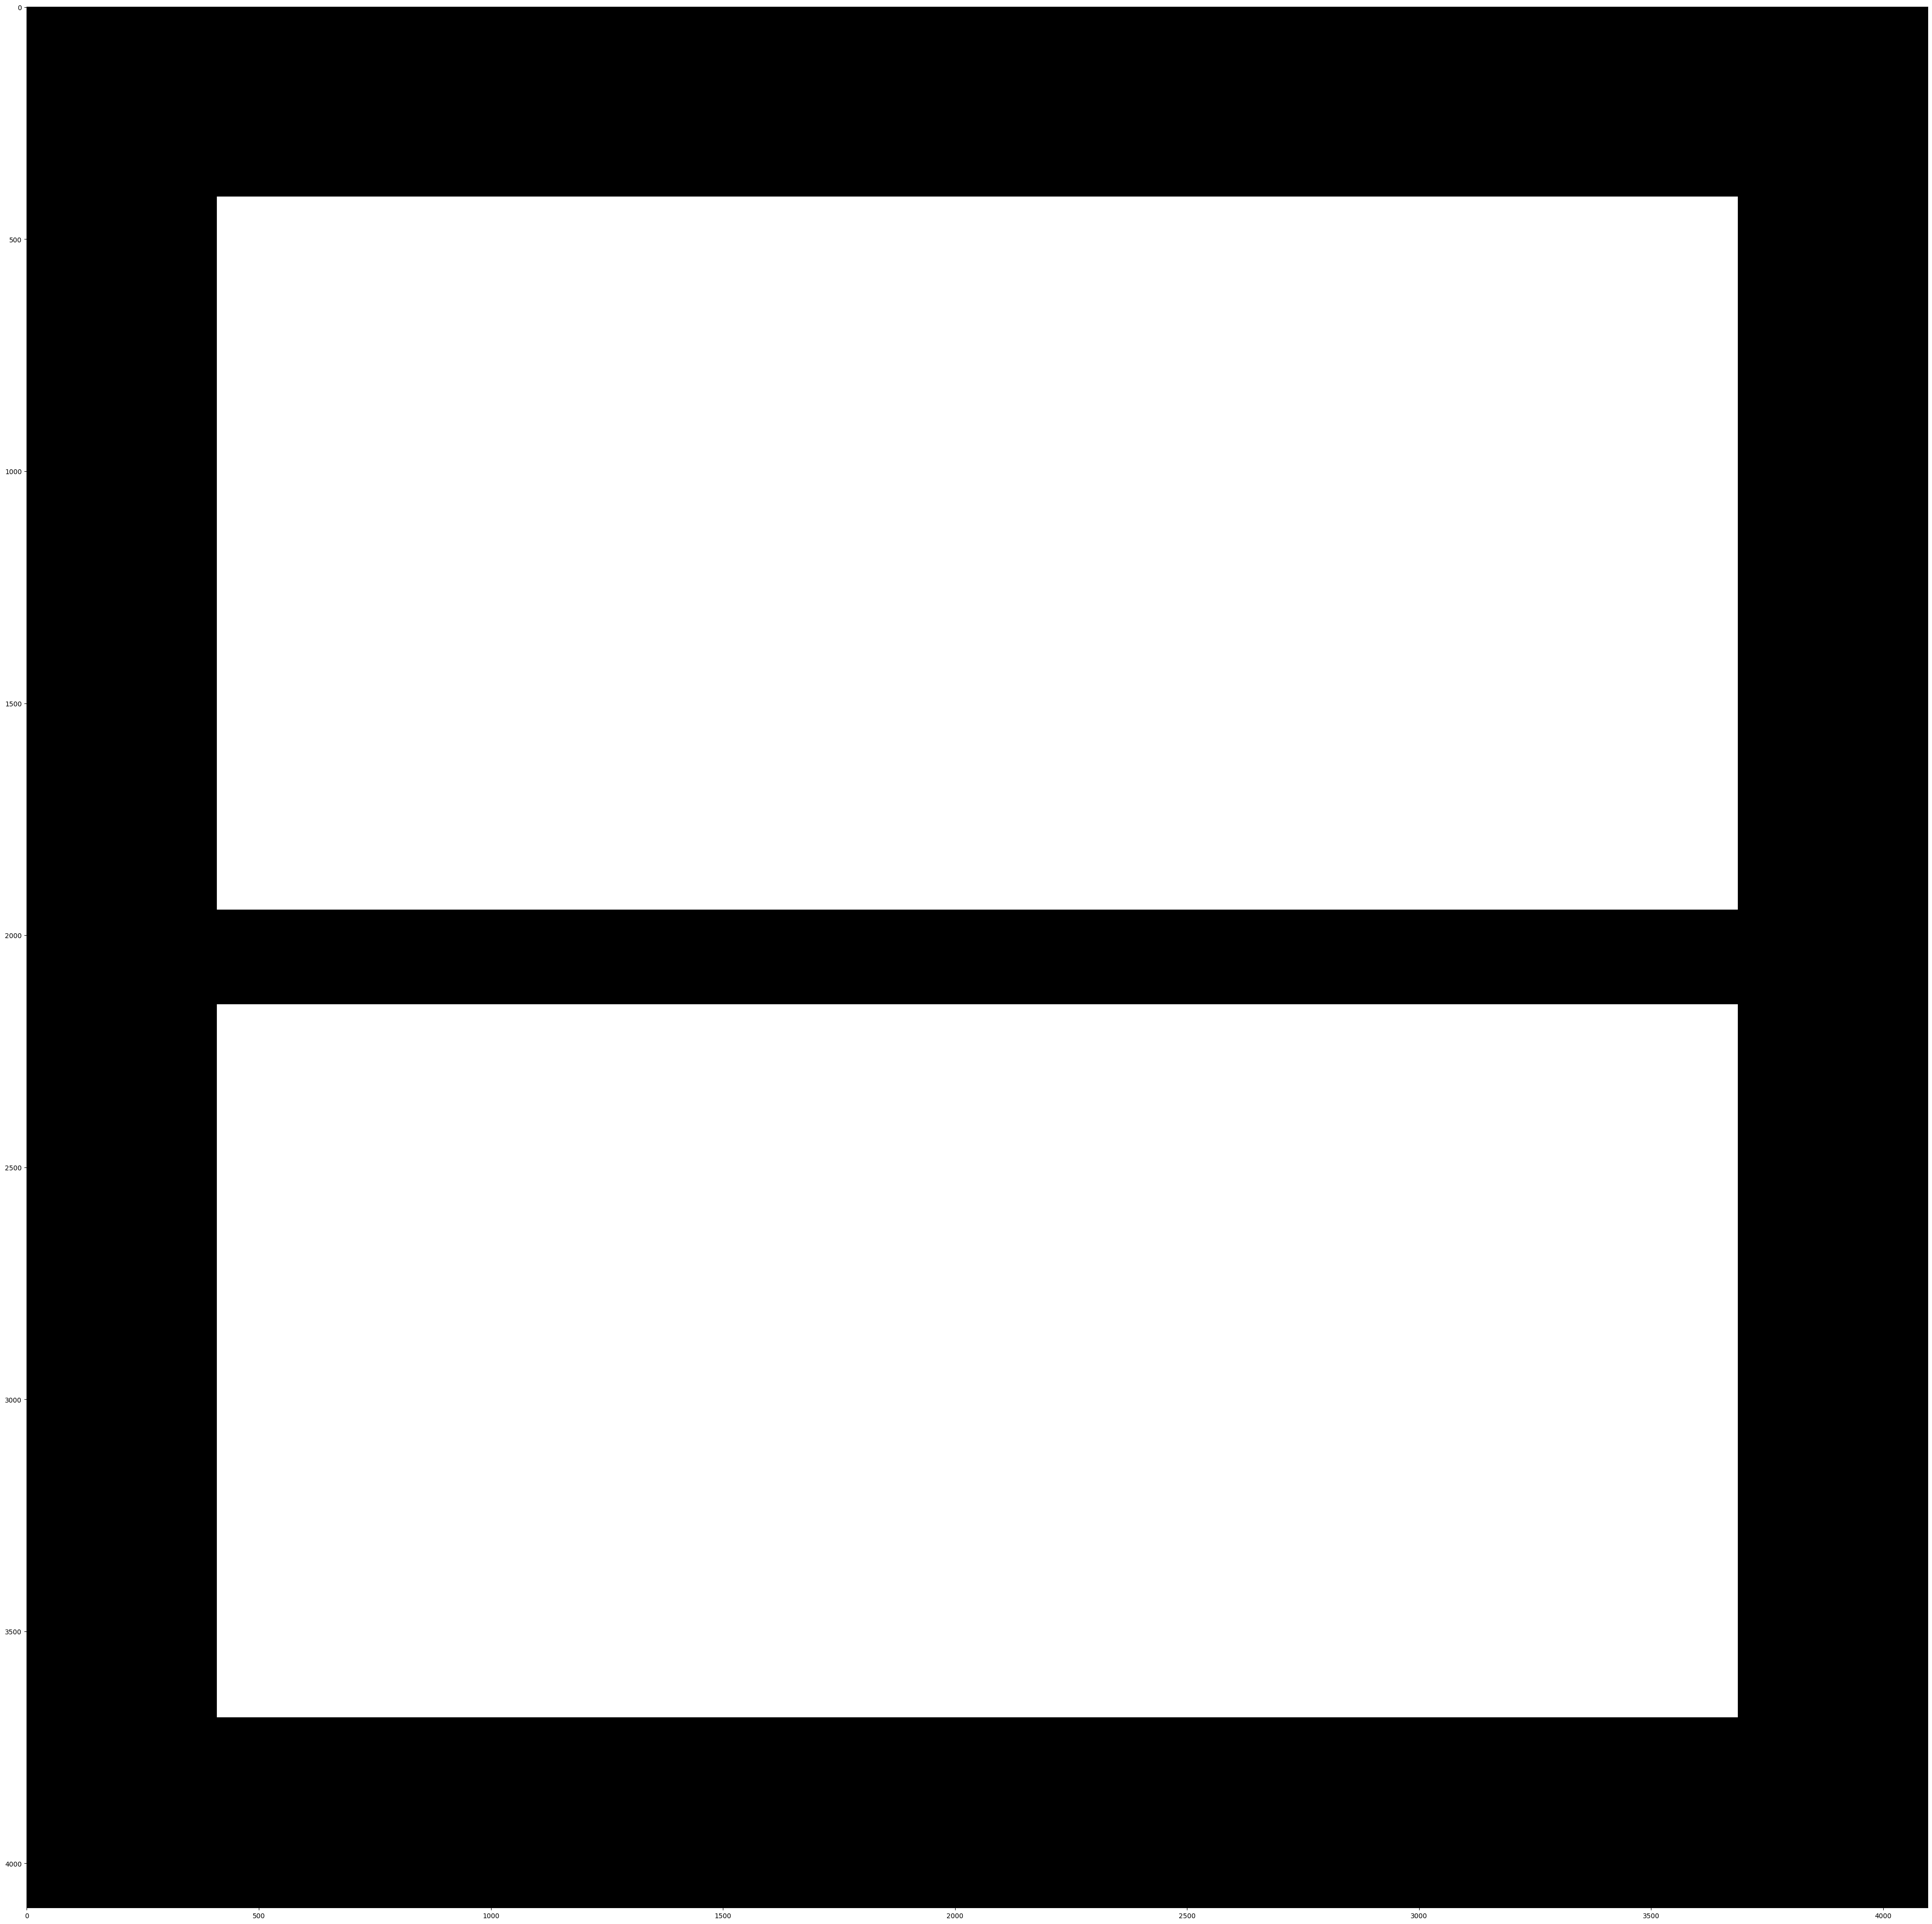

In [21]:
def generate_image(nx, ny, radius_in, radius_out):
    Y, X = np.meshgrid(np.linspace(-1, 1, ny, endpoint=True), np.linspace(-1, 1, nx, endpoint=True))
    image_aperture = (X**2 > radius_in**2)  # the horizontal band outside radius_in
    image_aperture *= (Y**2 < radius_out**2) # the vertical band inside radius_out
    image_aperture *= (X**2 < radius_out**2)  # the horizontal band inside radius_out
    return image_aperture*1.

image_aperture = generate_image(nx=opt.nx, ny=opt.ny, radius_in=opt.radius_in, radius_out=opt.radius_out)

fig, ax = plt.subplots(figsize=(opt.ny/opt.bin_dens/dpi, opt.nx/opt.bin_dens/dpi), subplotpars=subplotpars)

ax.imshow(image_aperture, cmap='gray');

In [22]:
image_aperture.min(), image_aperture.max(), opt.nx, opt.ny

(np.float64(0.0), np.float64(1.0), 4096, 4096)

In [23]:
# image_aperture = None

## génération de la caustique


In [24]:
import numpy as np
# Example: list of (H, W, 3) arrays
arrays = [np.random.rand(10, 10, 3) for _ in range(5)]  # Replace with your actual list of arrays

# Sum all arrays in the list
summed_array = np.sum(arrays, axis=0)
summed_array.shape

(10, 10, 3)

In [ ]:
output_filename = c.plot(z, image_aperture)

Scanning time:   0%|          | 0/192 [00:00<?, ?it/s]

In [ ]:
c.show(output_filename)

In [ ]:
len(c.rgbs)

40

# exploration des paramètres


In [ ]:
N_scan = 5
base = 2

## profondeur d'eau


In [ ]:
for H_ in opt.H*np.logspace(-1, 1, N_scan, base=base):    
    c = Caustique(init(tag=f'{opt.tag}_H_{H_:.3f}', H = H_))
    output_filename = c.plot(z, image_aperture)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if opt.do_display: c.show(output_filename)

Scanning time:   0%|          | 0/192 [00:00<?, ?it/s]

Generating movie:   0%|          | 0/192 [00:00<?, ?it/s]

H = 200.000 -> output_filename='2025-11-04_caustique-focus/caustique_H_200.000_78830f60.mp4' 


Scanning time:   0%|          | 0/192 [00:00<?, ?it/s]

## variation de l'indice de réfraction


In [ ]:
# for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
#     opt = init()
#     c = Caustique(opt)
#     opt.variation = variation_
#     opt.tag = f'{opt.tag}_variation_{variation_:.3f}'

#     output_filename = c.plot(z, image_aperture)
#     print(f'variation = {variation_:.3f}  -> {output_filename=}')
#     if opt.do_display: c.show(output_filename)

## post-processing

In [ ]:
# for variable in ['gamma', 'min_lum', 'sigma']: 
for variable in ['gamma']: 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        c = Caustique(init(tag=f'{opt.tag}_{variable}_modul_{modul:.3f}'))
        c.d[variable] *= modul
        
        output_filename = c.plot(z, image_aperture)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if opt.do_display: c.show(output_filename)


## paramètres de l'ouverture


In [ ]:
for radius_in in np.linspace(0, opt.radius_out, N_scan+1)[:-1]:
    c = Caustique(init(tag=f'{opt.tag}_image_{radius_in=:.3f}'))

    output_filename = c.plot(z, generate_image(nx=opt.nx, ny=opt.ny, radius_in=radius_in, radius_out=opt.radius_out))
    print(f'{radius_in=:.3f} -> {output_filename=} ')
    if opt.do_display: c.show(output_filename)

In [ ]:
for radius_out in np.linspace(opt.radius_in, 1, N_scan+1)[1:]:
    c = Caustique(init(tag=f'{opt.tag}_image_{radius_out=:.3f}'))

    output_filename = c.plot(z, generate_image(nx=opt.nx, ny=opt.ny, radius_in=opt.radius_in, radius_out=radius_out))
    print(f'{radius_out=:.3f} -> {output_filename=} ')
    if opt.do_display: c.show(output_filename)

## autres instances de l'onde


In [ ]:
for seed_increment in range(N_scan):
    c = Caustique(init(tag=f'{opt.tag}_seed_{c.d['seed']}'))
    c.d['seed'] = c.d['seed'] + seed_increment
    output_filename = c.get_filename()
    if not(os.path.isfile(output_filename)):
        output_filename = c.plot(c.wave(do_cache=False), image_aperture)
    print(f'seed={c.d['seed']} -> {output_filename=}')
    if opt.do_display: c.show(output_filename)

## autres variables sur l'onde


In [ ]:
opt = init()
for variable in ['theta',  'B_theta', 'sf_0', 'B_V', 'B_sf', ]: #  'V_Y', 'V_X', , 'zmin'
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        # del z
        # print(opt.tag, variable, modul, f'{opt.tag}_{variable}_modul_{modul:.3f}')
        c = Caustique(init(tag=f'{opt.tag}_{variable}_modul_{modul:.3f}'))
        c.d[variable] *= modul
        
        output_filename = c.get_filename()
        if not(os.path.isfile(output_filename)):
            z = c.wave(do_cache=False)
            print(z.shape, z.min(), z.mean(), z.max())
            output_filename = c.plot(z, image_aperture)
            print(z.shape, z.min(), z.mean(), z.max())
            # assert(output_filename == output_filename_)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if opt.do_display: c.show(output_filename)

## une longue vague


In [ ]:
# %ls -lh {study_name}/longue*
# %ls -lh /tmp/{study_name}/longue*

In [ ]:
# %rm -fr {study_name}/longue*
# %rm -fr ~/tmp/{study_name}/longue*

In [ ]:
print('====== long wave ======')
c = Caustique(init(tag='longue'))
c.opt


In [ ]:
# N_wave = 4 * PRECISION
# N_wave = 5
N_wave = 25
N_wave = 50
# N_wave = 75
kappa = .5 # dispersion of the modulation
amplitude = np.exp(kappa * (np.cos((np.linspace(0, 1, N_wave)-.50)*2*np.pi) -1) )
modul = 0.5
kappa = 2.5 # dispersion of the modulation
B_Vs = c.opt.B_V * ( 1 + modul * np.exp(kappa * (np.cos((np.linspace(0, 1, N_wave)-.25)*2*np.pi) -1) ))
B_sfs = c.opt.B_sf * ( 1 + modul * np.exp(kappa * (np.cos((np.linspace(0, 1, N_wave)-.50)*2*np.pi) -1) ))
B_thetas = c.opt.B_theta / ( 1 + modul * np.exp(kappa * (np.cos((np.linspace(0, 1, N_wave)-.75)*2*np.pi) -1) ))
# sf_0s = c.opt.sf_0 / ( 1 + modul * np.exp(kappa * (np.cos((np.linspace(0, 1, N_wave)-.75)*2*np.pi) ) ))


In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8))
ax[0].plot(amplitude)
ax[0].set_title('Amplitude')
ax[0].set_xticks([])
ax[1].plot(B_thetas)
ax[1].set_title('B_theta')
ax[1].set_xticks([])
ax[2].plot(B_sfs)
ax[2].set_title('B_sfs')
ax[2].set_xticks([])
ax[3].plot(B_Vs)
ax[3].set_title('B_V')
# ax[3].plot(sf_0s)
# ax[3].set_title('sf_0')
plt.show()

In [ ]:
c_chunk = Caustique(init())
# print(f'{c.cachepath}/{c.opt.tag}_vague-smooth_0.npy')
if not(os.path.isfile(f'{c.cachepath}/{c.opt.tag}_vague-smooth_0.npy')):
    print('Computing waves...')
    # z_updates = []
    for i_wave in trange(N_wave):
        fname = f'{c.cachepath}/{c.opt.tag}_vague_{i_wave}.npy'
        if not(os.path.isfile(fname)):
            #     z_update = np.load(fname)
            # else:        
            # c_chunk = Caustique(init())
            c_chunk.opt.B_sf = B_sfs[i_wave]
            c_chunk.opt.B_theta = B_thetas[i_wave]
            # c_chunk.opt.sf_0 = sf_0s[i_wave]
            c_chunk.opt.B_V = B_Vs[i_wave]
            c_chunk.opt.seed = opt.seed + i_wave

            z_update = amplitude[i_wave] * c_chunk.wave(do_cache=False)
            np.save(fname, z_update)
        # z_updates.append(z_update)

smooth = (c_chunk.ft - c_chunk.ft.min())/(c_chunk.ft.max() - c_chunk.ft.min()) # smoothly progress from 0. to 1.
del c_chunk
# z = np.zeros((opt.nx, opt.ny, 0))
for i_wave in trange(N_wave):
    fname = f'{c.cachepath}/{c.opt.tag}_vague-smooth_{i_wave}.npy'

    if not(os.path.isfile(fname)):
        z_previous_update = np.load(f'{c.cachepath}/{c.opt.tag}_vague_{(i_wave-1) % N_wave}.npy')
        z_update = np.load(f'{c.cachepath}/{c.opt.tag}_vague_{i_wave}.npy')
        z_smooth = (1.-smooth)*z_previous_update + smooth*z_update
        # z = np.concatenate((z, z_smooth), axis=-1)
        np.save(fname, z_smooth)

        del z_previous_update
        del z_smooth
        del z_update
del smooth

In [ ]:
print(c.opt)

In [ ]:
# z.shape, z.min(), z.mean(), z.max()

In [ ]:
%whos

In [ ]:
output_filename = c.get_filename(note='_vague')
if not(os.path.isfile(output_filename)):

    with imageio.v2.get_writer(
        output_filename,
        format='FFmpeg', 
        mode='I',
        # format='av', 
        fps=opt.fps,
        # pixelformat=pix_fmt
        # codec='ffv1',  # Use FFV1 for lossless compression
        ) as writer:

        for i_wave in trange(N_wave, desc='Generating movie'):
            z_smooth = np.load(f'{c.cachepath}/{c.opt.tag}_vague-smooth_{i_wave}.npy')
    
            for i_frame in range(z_smooth.shape[-1]):
                # Append the frame to the video writer
                writer.append_data((z_smooth[..., i_frame]*(2**c.opt.n_bits-1)).astype(c.np_dtype))

            
                
    # z_q = (z*(2**c.opt.n_bits-1)).astype(c.np_dtype)
    # print(z_q.shape, z_q.min(), z_q.mean(), z_q.max())
    # output_filename = make_mp4(output_filename, z_q, fps=opt.fps)
    del z_smooth
# del z
c.show(output_filename)

In [ ]:
# for i_wave in trange(N_wave):
#     fname = f'{c.cachepath}/{c.opt.tag}_vague_{i_wave}.npy'
#     os.remove(fname)

## la caustique de la longue vague


In [ ]:
image_rgb_max = 0.
for i_wave in trange(N_wave):
    fname = f'{c.cachepath}/{c.opt.tag}_caustique_{i_wave}.npy'
    if os.path.isfile(fname):
        image_update = np.load(fname)
    else:
        z_smooth = np.load(f'{c.cachepath}/{c.opt.tag}_vague-smooth_{i_wave}.npy')
        image_update = c.compute(z_smooth, image_aperture)
        np.save(fname, image_update)
        del z_smooth 
    
    image_rgb_max = max(image_rgb_max, image_update.max())    
    del image_update
print(f'{image_rgb_max=}')

In [ ]:
%whos

In [ ]:
output_filename = c.get_filename(note='_caustique')
if not(os.path.isfile(output_filename)):

    with imageio.v2.get_writer(
        output_filename,
        format='FFmpeg', 
        mode='I',
        # format='av', 
        fps=opt.fps,
        # pixelformat=pix_fmt
        # codec='ffv1',  # Use FFV1 for lossless compression
        ) as writer:

        for i_wave in trange(N_wave, desc='Generating movie'):
            fname = f'{c.cachepath}/{c.opt.tag}_caustique_{i_wave}.npy'
            frames = np.load(fname)

            frames /= image_rgb_max
            frames = frames ** (1/opt.gamma)

            for i_frame in range(frames.shape[-1]):
                # Append the frame to the video writer
                writer.append_data((frames[..., i_frame]*(2**c.opt.n_bits-1)).astype(c.np_dtype))

c.show(output_filename)

In [ ]:
print(output_filename)